In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import warnings
import datetime as dt
import cufflinks as cf
import plotly.plotly as py
warnings.filterwarnings('ignore')
import plotly
plotly.tools.set_credentials_file(username='soyarielruiz', api_key='Io0U7KvMLYpCw01a1vNJ')
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

In [2]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
    'nombre_area': 'category'
})


# Ajustes en los archivos antes de procesar

In [3]:
areas_agrupadas = pd.read_csv('../extraData/areas_agrupadas.csv')

In [4]:
# Agrupo las áreas parecidas.
avisos_detalles = pd.merge(avisos_detalles, areas_agrupadas, how='inner', on='nombre_area')
avisos_detalles['nombre_area'] = avisos_detalles['nuevo_nombre_area']
avisos_detalles.drop('nuevo_nombre_area', axis=1, inplace=True)

In [5]:
# Convierto el nombre del area a category.
avisos_detalles['nombre_area'] = avisos_detalles['nombre_area'].astype('category')

In [6]:
# Recorto la columna idpais ya que no es necesaria.
#avisos_detalles.drop('idpais', axis=1, inplace=True)
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

In [7]:
# Cambiar el tipo de dato de la fecha de postulacion.
postulaciones[['fechapostulacion']] = postulaciones[['fechapostulacion']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)


Timestamp('2018-04-09 19:59:16.920859')

# Empieza el analisis

In [8]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = [{'nombre': 'Otro', 'estado': 'Abandonado',    'valor_educacion': 1    },
    {'nombre': 'Otro',                  'estado': 'En Curso',    'valor_educacion': 2    },
    {'nombre': 'Otro',                  'estado': 'Graduado',    'valor_educacion': 3    },
    {'nombre': 'Secundario',            'estado': 'Abandonado',    'valor_educacion': 4    },
    {'nombre': 'Secundario',            'estado': 'En Curso',    'valor_educacion': 5    },
    {'nombre': 'Secundario',        'estado': 'Graduado',    'valor_educacion': 6    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Abandonado',    'valor_educacion': 7    },
    {'nombre': 'Universitario',     'estado': 'Abandonado',    'valor_educacion': 8    },
    {'nombre': 'Terciario/Técnico', 'estado': 'En Curso',    'valor_educacion': 9    },
    {'nombre': 'Universitario',     'estado': 'En Curso',    'valor_educacion': 10    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Graduado',    'valor_educacion': 11    },
    {'nombre': 'Universitario',     'estado': 'Graduado',    'valor_educacion': 12    },
    {'nombre': 'Posgrado',          'estado': 'Abandonado',    'valor_educacion': 13    },
    {'nombre': 'Master',            'estado': 'Abandonado',    'valor_educacion': 14    },
    {'nombre': 'Posgrado',          'estado': 'En Curso',    'valor_educacion': 15    },
    {'nombre': 'Master',            'estado': 'En Curso',    'valor_educacion': 16    },
    {'nombre': 'Posgrado',          'estado': 'Graduado',    'valor_educacion': 17    },
    {'nombre': 'Master',            'estado': 'Graduado',    'valor_educacion': 18    },
    {'nombre': 'Doctorado',         'estado': 'Abandonado',    'valor_educacion': 19    },
    {'nombre': 'Doctorado',         'estado': 'En Curso',    'valor_educacion': 20    },
    {'nombre': 'Doctorado',         'estado': 'Graduado',    'valor_educacion': 21 }]
valores_educacion = pd.DataFrame(valores_educacion)

In [9]:
valores_educacion.nombre = valores_educacion.nombre.astype('category', categories=post_educacion.nombre.cat.categories)
valores_educacion.memory_usage(deep=True)

Index                80
estado             1379
nombre              850
valor_educacion     168
dtype: int64

In [10]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion,  how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

In [11]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()
max_post_educacion.count()

idpostulante       188752
valor_educacion    188752
dtype: int64

In [12]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], right_on = ['idpostulante','valor_educacion'])

post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [13]:
postulantes = pd.merge(post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
postulantes.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
0,NdJl,Posgrado,En Curso,15,1969-05-09,MASC,48.0
1,axaPJ,Posgrado,En Curso,15,1970-01-06,MASC,48.0
2,Z48mz,Posgrado,En Curso,15,1967-05-16,MASC,50.0
3,a4zEZ,Posgrado,En Curso,15,1976-04-10,MASC,41.0
4,6AWqO,Posgrado,En Curso,15,1970-05-21,MASC,47.0


## Ver postulaciones de secundario en curso y vistas hechas al respecto (vistas, postulaciones, área de trabajo).


In [14]:
postulantes_sec = postulantes.loc[(postulantes['nombre'] == 'Secundario') & (postulantes['estado'] == 'En Curso')]
postulantes_sec.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
54977,1qkm9z,Secundario,En Curso,5,1976-09-18,MASC,41.0
54978,YvjkMV,Secundario,En Curso,5,1975-06-18,FEM,42.0
54979,Y4oJ9w,Secundario,En Curso,5,1985-09-24,MASC,32.0
54980,5L5akv,Secundario,En Curso,5,1985-10-12,MASC,32.0
54981,6ZkmJR,Secundario,En Curso,5,1984-01-08,MASC,34.0


In [ ]:
#postulantes_1 = postulantes_sec[postulantes_sec.isna().any(axis=1)]
#null_columns=postulantes_sec.columns[postulantes_sec.isnull().any()]
#print(postulantes_sec[postulantes_sec.isnull().any(axis=1)][null_columns].head())
#aa = postulantes_sec.dropna(axis=0)

In [15]:
#pd.to_datetime(postulantes_sec['fechapostulacion'])
#postulantes_sec['edad'] = (now - pd.to_datetime(postulantes_sec['fechanacimiento'])).astype('<m8[Y]')
#dejo solo los mayores de edad y menores a la edad de jubilacion
postulantes_sec = postulantes_sec.loc[(postulantes_sec['edad'] >= 18) & (postulantes_sec['edad'] <= 65)]
#postulantes_sec.sort_values('age')
#veo el promedio de edad que utilizan la pagina y poseen secundario en curso
pd.to_numeric(postulantes_sec['edad'])

54977    41.0
54978    42.0
54979    32.0
54980    32.0
54981    34.0
54982    42.0
54983    35.0
54984    37.0
54985    36.0
54986    42.0
54987    33.0
54988    34.0
54989    42.0
54990    30.0
54991    40.0
54992    56.0
54993    31.0
54994    47.0
54995    31.0
54996    31.0
54997    33.0
54998    32.0
54999    30.0
55000    49.0
55001    37.0
55002    38.0
55003    28.0
55004    37.0
55005    33.0
55006    28.0
         ... 
58341    18.0
58342    30.0
58344    19.0
58345    18.0
58346    19.0
58347    21.0
58348    22.0
58349    36.0
58350    22.0
58351    37.0
58352    19.0
58353    19.0
58354    19.0
58355    19.0
58356    22.0
58357    18.0
58358    21.0
58360    21.0
58361    19.0
58362    18.0
58363    27.0
58364    18.0
58365    20.0
58366    19.0
58367    27.0
58368    18.0
58369    18.0
58370    22.0
58371    18.0
58372    19.0
Name: edad, Length: 3250, dtype: float64

In [16]:
#obtengo las decadas correspondientes para agrupar
postulantes_sec['decil'] = np.floor( postulantes_sec['edad'].apply(lambda x: x /10) )
postulantes_sec['decil'] = postulantes_sec['decil'].apply(lambda x: x*10)
postulantes_sec.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad,decil
54977,1qkm9z,Secundario,En Curso,5,1976-09-18,MASC,41.0,40.0
54978,YvjkMV,Secundario,En Curso,5,1975-06-18,FEM,42.0,40.0
54979,Y4oJ9w,Secundario,En Curso,5,1985-09-24,MASC,32.0,30.0
54980,5L5akv,Secundario,En Curso,5,1985-10-12,MASC,32.0,30.0
54981,6ZkmJR,Secundario,En Curso,5,1984-01-08,MASC,34.0,30.0


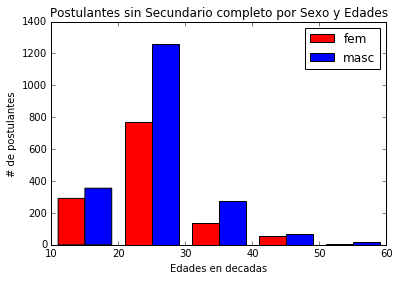

In [17]:
#diferencio entre mujeres y hombres
sec_fem = postulantes_sec.loc[postulantes_sec['sexo'] == 'FEM']
sec_masc = postulantes_sec.loc[postulantes_sec['sexo'] == 'MASC']
plt.xlabel('Edades en decadas')
plt.ylabel('# de postulantes')
plt.title('Postulantes sin Secundario completo por Sexo y Edades')
plt.hist([sec_fem['decil'],sec_masc['decil']], bins=5, color=['red', 'blue'], label=['fem','masc'])
plt.legend()

In [18]:
#veo las postulaciones que han hecho los que no poseen secundario completo
#ejemplo usado https://plot.ly/pandas/bubble-charts/
mergeo_sec = pd.merge(postulantes_sec, postulaciones)
agrup_sec = mergeo_sec.groupby(['idaviso']).size().to_frame(name='count').reset_index()
secs = pd.merge(avisos_detalles, agrup_sec, on='idaviso')
secs.drop(['mapacalle','titulo','ciudad','nombre_zona','descripcion'],1,inplace=True)
#secs.sort_values(by='count',ascending=False)
secs_emp = secs[secs['count'] > 100]
secs_emp.sort_values(by='count',ascending=True)
secs_emp.iplot(kind='bubble', size='count', text='count', y='nombre_area', x='denominacion_empresa', mode='markers',
color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)', 'rgb(44, 160, 101)', 'rgb(255, 65, 54)'], 
     opacity=[1, 0.8, 0.6, 0.4],filename='simple-bubble-chart',title='Postulaciones Secundario Incompleto')

### Por ello suponemos que una persona con secundario en curso se postula principalmente en mantenimiento y limpieza, ventas y en menor medida en produccion. 

# Ahora comparo con las vistas que hizo

In [19]:
sec_vistas = pd.merge(postulantes_sec, vistas)
sec_vistas = sec_vistas.rename(columns={"idAviso": "idaviso"})
secus_views = sec_vistas.groupby(['idaviso']).size().to_frame(name='count_vistas').reset_index()
secus_views_avisos = pd.merge(avisos_detalles, secus_views)
secus_views_avisos.drop(['mapacalle','titulo','ciudad','nombre_zona','descripcion'],1,inplace=True)
sec_max = secus_views_avisos[secus_views_avisos['count_vistas'] > 40]
sec_max.sort_values(by='count_vistas', ascending=True, inplace=True)
sec_max.iplot(kind='bubble', size='count_vistas', text='count_vistas', y='nombre_area', x='denominacion_empresa', filename='simple-bubble-chart', title='Vistas postulantes Secundario Incompleto')

### En este ejemplo visualizamos que las vistas corresponden mayormente a Mantenimiento y Limpieza siguiendo muy de lejos el rubro ventas.

In [31]:
#Ahora veo como distinguir las vistas de las postulaciones
#df_secs = pd.DataFrame({'post':secs_emp, 'view': sec_max})
secs_emp.head()


merged = pd.merge(secs_emp, sec_max, on=['idaviso', 'idpais', 'tipo_de_trabajo', 'nivel_laboral', 'nombre_area', 'denominacion_empresa'], how='inner')
#merged.head()
#merged.iplot(kind='bubble', size='count_vistas', text='count_vistas', y='nombre_area', x='denominacion_empresa', filename='simple-bubble-chart', title='Vistas vs Postulaciones Secundario Incompleto', dimensions=)

TypeError: only length-1 arrays can be converted to Python scalars

# Voy a ver comparativamente con postulantes que poseen otros niveles de estudio.

In [20]:
#postulantes.head()
#postulaciones.head()
post_all = pd.merge(postulaciones, postulantes)
total_post = post_all.groupby(['idaviso']).size().to_frame(name='count_post').reset_index()
total_views_avisos = pd.merge(avisos_detalles, total_post)
total_views_avisos.drop(['mapacalle','titulo','ciudad','nombre_zona','descripcion'],1,inplace=True)
total_views_avisos_min = total_views_avisos[total_views_avisos['count_post'] > 500]
total_views_avisos_min.iplot(kind='bubble', size='count_post', text='count_post', y='nivel_laboral', x='nombre_area', filename='simple-bubble-chart', title='Postulaciones totales por area y nivel laboral')

# Visualizo con graduados de posgrado

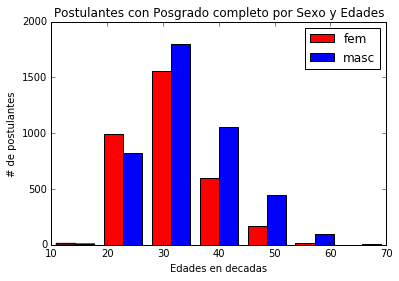

In [42]:
#post_all = pd.merge(postulaciones, postulantes)
#
postulantes_postgrado = postulantes[postulantes.valor_educacion > 15]
#obtengo las decadas correspondientes para agrupar
postulantes_postgrado['decil'] = np.floor( postulantes_postgrado['edad'].apply(lambda x: x /10) )
postulantes_postgrado['decil'] = postulantes_postgrado['decil'].apply(lambda x: x*10)
post_fem = postulantes_postgrado.loc[postulantes_postgrado['sexo'] == 'FEM']
post_masc = postulantes_postgrado.loc[postulantes_postgrado['sexo'] == 'MASC']
#post_fem = post_fem[post_fem['edad'] < 21]
#post_fem.head(50)
#post_fem[post_fem.edad < 24]
plt.xlabel('Edades en decadas')
plt.ylabel('# de postulantes')
plt.title('Postulantes con Posgrado completo por Sexo y Edades')
plt.hist([post_fem['decil'].dropna(),post_masc['decil'].dropna()], bins=7, color=['red', 'blue'], label=['fem','masc'])
plt.legend()
plt.show()

### Me parece raro que menores de 20 años tengan posgrado en curso, o master, etc.

In [22]:
#df = pd.DataFrame(, columns=['a', 'b', 'c', 'd'])
#postulantes_postgrado.plot.area(stacked=False);
from pandas.plotting import andrews_curves
#andrews_curves(postulantes_postgrado, 'edad')
#andrews_curves(postulantes_postgrado, 'edad')
postulantes_postgrado.dtypes

idpostulante               object
nombre                   category
estado                     object
valor_educacion             int64
fechanacimiento    datetime64[ns]
sexo                     category
edad                      float64
decil                     float64
dtype: object

In [54]:
# Recorto la columna idpais ya que no es necesaria.
#avisos_detalles.drop(['mapacalle','ciudad','nombre_zona'], axis=1, inplace=True)
avisos_detalles['sexo'] = avisos_detalles.descripcion.str.extract(r'(masculino|femenino|ambos sexos|hombre|mujer)')
avisos_detalles.groupby('sexo').count()

,idaviso,titulo,descripcion,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
sexo,,,,,,,
ambos sexos,68,68,68,68,68,68,68
femenino,82,82,82,82,82,82,82
hombre,54,54,54,54,54,54,54
masculino,383,383,383,383,383,383,382
mujer,71,71,71,71,71,71,71
